# NESO Regional Carbon Intensity and Generation Mix Data Transformation

### Notebook Objectives

### Primary Goals
- **Transform raw NESO regional carbon intensity data** into clean, analysis-ready format
- **Standardise datetime handling** across all energy datasets
- **Create consistent regional mapping** for geographic analysis
- **Generate summary statistics** and data quality reports for carbon intensity trends

### User Stories
> **As a data analyst**, I want clear documentation and explanations for each NESO dataset we extract so that I and other team members can understand the source, structure, meaning and caveats of the data without digging into code.

> **As a climate researcher**, I want standardised regional carbon intensity data so that I can easily identify the cleanest and dirtiest electricity by time and location across Great Britain.

> **As an energy consumer**, I want reliable carbon intensity transformation pipelines so that I can trust insights about when and where to use electricity most sustainably.

### About This Notebook

### Source Data Combined
- **NESO Historic Generation Mix**: Complete 30-minute generation data by fuel type (2009-2025)
- **NESO Regional Carbon Intensity**: Regional carbon intensity forecasts with 1.1% missing timestamps
- **Integration Method**: Full outer join to capture all timestamps from both datasets
- **Time Resolution**: 30-minute intervals maintained
- **Geographic Coverage**: Great Britain transmission system with 14 regional breakdowns
- **Attribution**: "Supported by National Energy SO Open Data"

#### Stage 1: Environment Setup
Here we import the python libraries we need ready to conduct the join, tranformation to validate the integrity of the dataset and make alterations where nessesary.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# For imputation and quality assesment
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from scipy import stats

In [2]:
# Assign processed data directory 
processed_dir = "../data/processed"
dict_dir = '../data/data_dictionary'
stats_dir = '../data/descriptive_statistics'

print(f"{processed_dir}/ - Clean datasets for analysis")
print(f"{dict_dir}/ - Data dictionaries and documentation")
print(f"{stats_dir}/ - Descriptive statistics and summaries")

../data/processed/ - Clean datasets for analysis
../data/data_dictionary/ - Data dictionaries and documentation
../data/descriptive_statistics/ - Descriptive statistics and summaries


### Stage 2: Load processed data
Next we load in the data and check the shape and first few rows to validate with a small sample to initially verify if it has been read correctly.

In [3]:
# Load the processed regional carbon intensity data
generation_mix = pd.read_csv(r'../data/processed/generation_mix.csv')

# Check the row and column count and preview the first 5 rows
print(f"Loaded generation mix data: {generation_mix.shape[0]:,} rows × {generation_mix.shape[1]} columns")
generation_mix.head()

Loaded generation mix data: 291,216 rows × 34 columns


,DATETIME,GAS,COAL,NUCLEAR,WIND,WIND_EMB,HYDRO,IMPORTS,BIOMASS,OTHER,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,2009-01-01 00:00:00+00:00,8369.0,15037.0,7099.0,244.0,61.0,246,2519.0,0.0,0.0,...,7.5,0.0,0.0,0.0,0.0,100.0,22.8,24.5,1.6,69.7
1,2009-01-01 00:30:00+00:00,8498.0,15095.0,7088.0,225.0,56.0,245,2497.0,0.0,0.0,...,7.4,0.0,0.0,0.0,0.0,100.0,22.6,24.3,1.6,70.0
2,2009-01-01 01:00:00+00:00,8474.0,15088.0,7074.0,204.0,51.0,246,2466.0,0.0,0.0,...,7.3,0.0,0.0,0.0,0.0,100.0,22.5,24.2,1.5,70.1
3,2009-01-01 01:30:00+00:00,8319.0,15034.0,7064.0,188.0,47.0,246,2440.0,0.0,0.0,...,7.3,0.0,0.0,0.0,0.0,100.0,22.6,24.3,1.4,70.0
4,2009-01-01 02:00:00+00:00,8296.0,15004.0,7052.0,173.0,43.0,246,2364.0,0.0,0.0,...,7.1,0.0,0.0,0.0,0.0,100.0,22.6,24.3,1.4,70.2


In [4]:
# Load the processed regional carbon intensity data
regional_carbon_intensity = pd.read_csv(r'../data/processed/regional_carbon_intensity.csv')

# Check the row and column count and preview the first 5 rows
print(f"Loaded generation mix data: {regional_carbon_intensity.shape[0]:,} rows × {regional_carbon_intensity.shape[1]} columns")
regional_carbon_intensity.head()

Loaded generation mix data: 119,629 rows × 15 columns


,datetime,North Scotland,South Scotland,North West England,North East England,Yorkshire,North Wales and Merseyside,South Wales,West Midlands,East Midlands,East England,South West England,South England,London,South East England
0,2018-09-17 23:00:00+00:00,30.0,11.0,38.0,24.0,319.0,157.0,271.0,40.0,325.0,58.0,72.0,116.0,49.0,73.0
1,2018-09-17 23:30:00+00:00,44.0,7.0,41.0,30.0,298.0,183.0,157.0,39.0,340.0,61.0,90.0,152.0,69.0,70.0
2,2018-09-18 00:00:00+00:00,44.0,8.0,39.0,30.0,295.0,180.0,155.0,39.0,337.0,60.0,89.0,152.0,68.0,70.0
3,2018-09-18 00:30:00+00:00,44.0,11.0,37.0,31.0,288.0,175.0,151.0,38.0,330.0,58.0,87.0,150.0,69.0,70.0
4,2018-09-18 01:00:00+00:00,45.0,13.0,34.0,32.0,278.0,171.0,148.0,37.0,326.0,57.0,85.0,151.0,70.0,69.0


#### Stage 2: Compare the overlap of the time series datasets

In [5]:
# Convert datetime to Pandas Datetime
generation_mix['DATETIME'] = pd.to_datetime(generation_mix['DATETIME'])
regional_carbon_intensity['datetime'] = pd.to_datetime(regional_carbon_intensity['datetime'])

# Compare dataset date ranges
print(f"Generation Mix: {generation_mix['DATETIME'].min().date()} to {generation_mix['DATETIME'].max().date()}")
print(f"Regional CI:    {regional_carbon_intensity['datetime'].min().date()} to {regional_carbon_intensity['datetime'].max().date()}")

Generation Mix: 2009-01-01 to 2025-08-11
Regional CI:    2018-09-17 to 2025-08-13


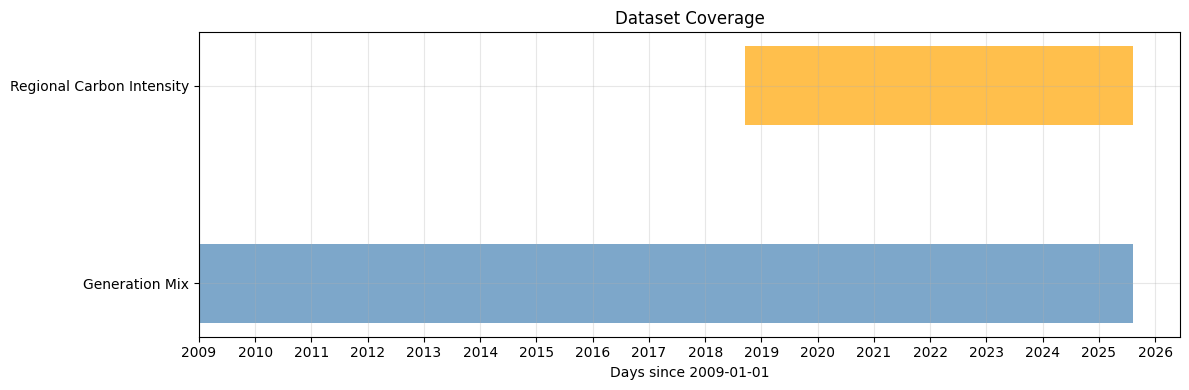

In [6]:
# Get date ranges
gen_start, gen_end = generation_mix['DATETIME'].min(), generation_mix['DATETIME'].max()
reg_start, reg_end = regional_carbon_intensity['datetime'].min(), regional_carbon_intensity['datetime'].max()

# Timeline Coverage
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.barh('Generation Mix', (gen_end - gen_start).days, 
        left=(gen_start - pd.Timestamp('2009-01-01', tz='UTC')).days,
        color='steelblue', alpha=0.7, height=0.4)
ax.barh('Regional Carbon Intensity', (reg_end - reg_start).days, 
        left=(reg_start - pd.Timestamp('2009-01-01', tz='UTC')).days,
        color='orange', alpha=0.7, height=0.4)

ax.set_xlabel('Days since 2009-01-01')
ax.set_title('Dataset Coverage')
ax.grid(True, alpha=0.3)

# Add year labels
years = pd.date_range('2009', '2026', freq='YS', tz='UTC')
ax.set_xticks([(y - pd.Timestamp('2009-01-01', tz='UTC')).days for y in years])
ax.set_xticklabels([y.strftime('%Y') for y in years])

plt.tight_layout()
plt.show()

#### Overlap Summary
To preserve the functionality of the full Generation Mix dataset, we will store two CSVs for the analysis, one complete Generation Mix dataset and a combined Regional Carbon Intensity dataset that fulfills the range that is currently availible from the Regional Carbon dataset. As the generation mix dataset is complete and not missing timestamps or data, we will use this as the base for the merge after slicing the dataset to the same data range as the Regional Carbon dataset.

#### Stage 3: Joining the Datasets

In [7]:
# Slice generation mix to match regional carbon intensity date range
generation_mix_sliced = generation_mix[
    (generation_mix['DATETIME'] >= reg_start) & 
    (generation_mix['DATETIME'] <= reg_end)
].copy()

# Perform full outer join to capture all timestamps from both datasets
combined_data = pd.merge(
    generation_mix_sliced, 
    regional_carbon_intensity, 
    left_on='DATETIME', 
    right_on='datetime', 
    how='outer',
    suffixes=('_gen', '_reg')
)

# Create unified datetime column (prefer generation mix datetime for consistency)
combined_data['datetime_unified'] = combined_data['DATETIME'].fillna(combined_data['datetime'])

# Drop redundant datetime columns
combined_data = combined_data.drop(['DATETIME', 'datetime'], axis=1)

# Rename unified datetime column
combined_data = combined_data.rename(columns={'datetime_unified': 'datetime'})

# Sort by datetime
combined_data = combined_data.sort_values('datetime').reset_index(drop=True)

print(f"Combined dataset: {len(combined_data):,} records")
print(f"Date range: {combined_data['datetime'].min().date()} to {combined_data['datetime'].max().date()}")
print(f"Missing generation mix records: {combined_data['GENERATION'].isnull().sum():,}")  # Due to the Carbon Intensity dataset having future predictions
print(f"Missing regional CI records: {combined_data['North Scotland'].isnull().sum():,}") # Original data quality issue

# Display first 5 rows
combined_data.head()

Combined dataset: 121,034 records
Date range: 2018-09-17 to 2025-08-13
Missing generation mix records: 72
Missing regional CI records: 2,716


,GAS,COAL,NUCLEAR,WIND,WIND_EMB,HYDRO,IMPORTS,BIOMASS,OTHER,SOLAR,...,North Wales and Merseyside,South Wales,West Midlands,East Midlands,East England,South West England,South England,London,South East England,datetime
0,3349.0,416.0,7242.0,7962.0,2085.0,366.0,1506.0,1783.0,81.0,0.0,...,157.0,271.0,40.0,325.0,58.0,72.0,116.0,49.0,73.0,2018-09-17 23:00:00+00:00
1,3399.0,412.0,7243.0,7756.0,2120.0,359.0,1456.0,1385.0,82.0,0.0,...,183.0,157.0,39.0,340.0,61.0,90.0,152.0,69.0,70.0,2018-09-17 23:30:00+00:00
2,3116.0,389.0,7247.0,7814.0,2151.0,348.0,1506.0,1385.0,82.0,0.0,...,180.0,155.0,39.0,337.0,60.0,89.0,152.0,68.0,70.0,2018-09-18 00:00:00+00:00
3,2975.0,390.0,7247.0,7829.0,2142.0,340.0,1482.0,1553.0,82.0,0.0,...,175.0,151.0,38.0,330.0,58.0,87.0,150.0,69.0,70.0,2018-09-18 00:30:00+00:00
4,2917.0,375.0,7248.0,7706.0,2117.0,334.0,1460.0,1585.0,82.0,0.0,...,171.0,148.0,37.0,326.0,57.0,85.0,151.0,70.0,69.0,2018-09-18 01:00:00+00:00


#### Stage 4: Custom Function to create Data Dictionary 

In [8]:

# Custom Function to create a comprehensive data dictionary for NESO Generation Mix dataset
# Takes a DataFrame and returns a data dictionary with NESO-specific column descriptions
def create_data_dictionary(combined_data):
    # Official descriptions from NESO Historic GB Generation Mix dataset
    # Source: https://www.neso.energy/data-portal/historic-generation-mix/historic_gb_generation_mix
    descriptions = {
        'DATETIME': 'Date and time of historic generation mix and carbon intensity, given in UTC (ISO 8601 format)',
        'GAS': 'Amount of generation delivered by gas fuel type (MW)',
        'COAL': 'Amount of generation delivered by coal fuel type (MW)',
        'NUCLEAR': 'Amount of generation delivered by nuclear fuel type (MW)',
        'WIND': 'Amount of generation delivered by wind fuel type (MW)',
        'WIND_EMB': 'Amount of generation delivered by embedded wind (MW)',
        'HYDRO': 'Amount of generation delivered by hydro fuel type (MW)',
        'IMPORTS': 'Interconnector imports (MW)',
        'BIOMASS': 'Amount of generation delivered by biomass fuel type (MW)',
        'OTHER': 'Amount of generation delivered by other fuel types (MW)',
        'SOLAR': 'Amount of generation delivered by solar fuel type (MW)',
        'STORAGE': 'Amount of generation delivered by storage (MW)',
        'GENERATION': 'Sum of gas, coal, nuclear, wind, hydro and imports (MW)',
        'CARBON_INTENSITY': 'Carbon intensity of electricity - CO2 emissions per kWh of electricity consumed (gCO2/kWh)',
        'LOW_CARBON': 'Low carbon generation - wind, solar, hydro, nuclear, biomass (MW)',
        'ZERO_CARBON': 'Zero carbon generation - wind, solar, hydro, nuclear (MW)',
        'RENEWABLE': 'Renewable generation - wind, hydro, solar (MW)',
        'FOSSIL': 'Fossil generation - coal, natural gas (MW)',
        'GAS_perc': 'Gas generation as percentage of total generation (%)',
        'COAL_perc': 'Coal generation as percentage of total generation (%)',
        'NUCLEAR_perc': 'Nuclear generation as percentage of total generation (%)',
        'WIND_perc': 'Wind generation as percentage of total generation (%)',
        'WIND_EMB_perc': 'Embedded wind generation as percentage of total generation (%)',
        'HYDRO_perc': 'Hydro generation as percentage of total generation (%)',
        'IMPORTS_perc': 'Interconnector imports as percentage of total generation (%)',
        'BIOMASS_perc': 'Biomass generation as percentage of total generation (%)',
        'OTHER_perc': 'Other generation as percentage of total generation (%)',
        'SOLAR_perc': 'Solar generation as percentage of total generation (%)',
        'STORAGE_perc': 'Storage as percentage of total generation (%)',
        'GENERATION_perc': 'Total generation (gas, coal, nuclear, wind, hydro, imports) as percentage (%)',
        'LOW_CARBON_perc': 'Low carbon generation as percentage of total generation (%)',
        'ZERO_CARBON_perc': 'Zero carbon generation as percentage of total generation (%)',
        'RENEWABLE_perc': 'Renewable generation as percentage of total generation (%)',
        'FOSSIL_perc': 'Fossil generation as percentage of total generation (%)',
        'North Scotland': 'North Scotland carbon intensity forecast, predicted using machine learning models and metered generation (gCO2/kWh)',
        'South Scotland': 'South Scotland carbon intensity forecast, predicted using machine learning models and metered generation (gCO2/kWh)',
        'North West England': 'North West England carbon intensity forecast, predicted using machine learning models and metered generation (gCO2/kWh)',
        'North East England': 'North East England carbon intensity forecast, predicted using machine learning models and metered generation (gCO2/kWh)',
        'Yorkshire': 'Yorkshire carbon intensity forecast, predicted using machine learning models and metered generation (gCO2/kWh)',
        'North Wales and Merseyside': 'North Wales and Merseyside carbon intensity forecast, predicted using machine learning models and metered generation (gCO2/kWh)',
        'South Wales': 'South Wales carbon intensity forecast, predicted using machine learning models and metered generation (gCO2/kWh)',
        'West Midlands': 'West Midlands carbon intensity forecast, predicted using machine learning models and metered generation (gCO2/kWh)',
        'East Midlands': 'East Midlands carbon intensity forecast, predicted using machine learning models and metered generation (gCO2/kWh)',
        'East England': 'East England carbon intensity forecast, predicted using machine learning models and metered generation (gCO2/kWh)',
        'South West England': 'South West England carbon intensity forecast, predicted using machine learning models and metered generation (gCO2/kWh)',
        'South England': 'South England carbon intensity forecast, predicted using machine learning models and metered generation (gCO2/kWh)',
        'London': 'London carbon intensity forecast, predicted using machine learning models and metered generation (gCO2/kWh)',
        'South East England': 'South East England carbon intensity forecast, predicted using machine learning models and metered generation (gCO2/kWh)',
        'datetime': 'Timestamp of record, given in UTC (Coordinated Universal Time)',
    }
    
    dictionary_data = []
    for column in combined_data.columns:
        # Get 3 sample values (non-null)
        sample_values = combined_data[column].dropna().head(3).tolist()
        sample_str = ', '.join([str(x) for x in sample_values])
        
        dictionary_data.append({
            'Column': column,
            'Data Type': str(combined_data[column].dtype),
            'Missing Values': combined_data[column].isnull().sum(),
            'Missing %': round((combined_data[column].isnull().sum() / len(combined_data)) * 100, 2),
            'Unique Values': combined_data[column].nunique(),
            'Sample Values': sample_str,
            'Description': descriptions.get(column, 'Additional column - description needed (may be new interconnector or generation type)')
        })
    return pd.DataFrame(dictionary_data)

# Store the dictionary in a variable
raw_data_dictionary = create_data_dictionary(combined_data)

# Display data dictionary
print("NESO Generation Mix Dataset - Data Dictionary")
raw_data_dictionary

NESO Generation Mix Dataset - Data Dictionary


,Column,Data Type,Missing Values,Missing %,Unique Values,Sample Values,Description
0,GAS,float64,72,0.06,22531,"3349.0, 3399.0, 3116.0",Amount of generation delivered by gas fuel typ...
1,COAL,float64,72,0.06,4761,"416.0, 412.0, 389.0",Amount of generation delivered by coal fuel ty...
2,NUCLEAR,float64,72,0.06,4703,"7242.0, 7243.0, 7247.0",Amount of generation delivered by nuclear fuel...
3,WIND,float64,72,0.06,15973,"7962.0, 7756.0, 7814.0",Amount of generation delivered by wind fuel ty...
4,WIND_EMB,float64,72,0.06,5250,"2085.0, 2120.0, 2151.0",Amount of generation delivered by embedded win...
5,HYDRO,float64,72,0.06,1154,"366.0, 359.0, 348.0",Amount of generation delivered by hydro fuel t...
6,IMPORTS,float64,72,0.06,7491,"1506.0, 1456.0, 1506.0",Interconnector imports (MW)
7,BIOMASS,float64,72,0.06,3200,"1783.0, 1385.0, 1385.0",Amount of generation delivered by biomass fuel...
8,OTHER,float64,72,0.06,1779,"81.0, 82.0, 82.0",Amount of generation delivered by other fuel t...
9,SOLAR,float64,72,0.06,9894,"0.0, 0.0, 0.0",Amount of generation delivered by solar fuel t...


#### Stage 5: Impute the missing values using KNN

In [9]:

# Analyse missing patterns
generation_missing = combined_data['GENERATION'].isnull().sum()
regional_cols = [col for col in combined_data.columns if col in [
    'North Scotland', 'South Scotland', 'North West England', 'North East England', 
    'Yorkshire', 'North Wales and Merseyside', 'South Wales', 'West Midlands', 
    'East Midlands', 'East England', 'South West England', 'South England', 
    'London', 'South East England'
]]
regional_missing = combined_data[regional_cols[0]].isnull().sum() if regional_cols else 0

print(f"\nFuture predictions (no generation data): {generation_missing:,} ({generation_missing/len(combined_data)*100:.2f}%)")
print(f"Missing regional CI records: {regional_missing:,} ({regional_missing/len(combined_data)*100:.2f}%)")



Future predictions (no generation data): 72 (0.06%)
Missing regional CI records: 2,716 (2.24%)


In [10]:
# Create a copy for imputation
combined_imputed = combined_data.copy()

# Strong features for KNN imputation
imputation_features = [
    'GENERATION', 'CARBON_INTENSITY', 'GAS', 'COAL', 'NUCLEAR', 'WIND', 
    'HYDRO', 'IMPORTS', 'BIOMASS', 'SOLAR', 'FOSSIL', 'LOW_CARBON', 
    'ZERO_CARBON', 'RENEWABLE'
]

# Filter to only include available features
available_features = [col for col in imputation_features if col in combined_imputed.columns]

# Only impute regional CI where generation data is available (not including future predictions)
imputation_mask = combined_imputed['GENERATION'].notnull()
imputation_subset = combined_imputed[imputation_mask].copy()

regional_missing_mask = imputation_subset[regional_cols].isnull().any(axis=1)

print(f"Imputing on {imputation_subset.shape[0]:,} records where generation data is available")

if len(imputation_subset) > 0 and regional_missing_mask.sum() > 0:
    # Prepare data for KNN imputation
    features_and_regions = available_features + regional_cols
    imputation_data = imputation_subset[features_and_regions].copy()
    
    # Print out the row cout for training the KNN
    complete_rows = imputation_data.dropna().shape[0]
    print(f"Complete rows for training KNN: {complete_rows:,}")
    
    # Apply KNN imputation
    print("Applying KNN imputation with k=3...")                # See Stage 7 for the performance comparison where different K values were evauluated for accuracy
    knn_imputer = KNNImputer(n_neighbors=3, weights='uniform')
    
    # Fit and transform the data
    imputed_values = knn_imputer.fit_transform(imputation_data)
    
    # Update the imputed dataset with new values
    for i, col in enumerate(features_and_regions):
        if col in regional_cols:
            # Only update the missing regional values, keep existing values
            missing_in_col = imputation_subset[col].isnull()
            combined_imputed.loc[imputation_mask & missing_in_col, col] = imputed_values[missing_in_col, i]
    
    print("KNN imputation completed successfully")
        
    # Verify imputation results
    regional_missing_after = combined_imputed.loc[imputation_mask, regional_cols[0]].isnull().sum()
    imputed_count = regional_missing - regional_missing_after
    print(f"Imputed {imputed_count:,} regional CI values")
        
else:
    print("No regional CI data to impute or no generation data available")


Imputing on 120,962 records where generation data is available
Complete rows for training KNN: 118,246
Applying KNN imputation with k=3...
KNN imputation completed successfully
Imputed 2,716 regional CI values


#### Stage 6: Validate my Imputed values

In [11]:
# Compare summary statistics
print("Descriptive statisttics review: Original vs Imputed")

# Initialise lists to store all statistics
regions_list = []
original_counts = []
imputed_counts = []
original_means = []
imputed_means = []
original_stds = []
imputed_stds = []
mean_differences = []
std_differences = []
imputation_rates = []
quality_scores = []

# Process all regions
for region in regional_cols:
    # Original data stats
    original_data = combined_data[combined_data[region].notnull()][region]
    
    # Imputed data only
    imputed_mask = combined_data[region].isnull() & combined_imputed[region].notnull()
    imputed_data = combined_imputed[imputed_mask][region]
    
    if len(original_data) > 0:  # Include regions even if no imputed data
        regions_list.append(region)
        original_counts.append(len(original_data))
        imputed_counts.append(len(imputed_data))
        
        # Calculate basic statistics
        orig_mean = original_data.mean()
        orig_std = original_data.std()
        
        original_means.append(round(orig_mean, 1))
        original_stds.append(round(orig_std, 1))
        
        if len(imputed_data) > 0:
            imp_mean = imputed_data.mean()
            imp_std = imputed_data.std()
            
            imputed_means.append(round(imp_mean, 1))
            imputed_stds.append(round(imp_std, 1))
            mean_differences.append(round(imp_mean - orig_mean, 1))
            std_differences.append(round(imp_std - orig_std, 1))
            
            # Custom quality score
            quality = 100 - abs((imp_mean - orig_mean) / orig_mean * 100) if orig_mean != 0 else 100
            quality_scores.append(round(max(0, quality), 1))
            
        else:
            # No imputed data for this region
            imputed_means.append(0.0)
            imputed_stds.append(0.0)
            mean_differences.append(0.0)
            std_differences.append(0.0)
            quality_scores.append(0.0)

# Output in a neat dataframe
summary_df = pd.DataFrame({
    'Region': regions_list,
    'Original_Count': original_counts,
    'Imputed_Count': imputed_counts,
    'Original_Mean': original_means,
    'Imputed_Mean': imputed_means,
    'Original_Std': original_stds,
    'Imputed_Std': imputed_stds,
    'Mean_Diff': mean_differences,
    'Std_Diff': std_differences,
    'Quality_Score_%': quality_scores,
})
# Add calculated columns
summary_df['Mean_Bias_%'] = round((summary_df['Mean_Diff'] / summary_df['Original_Mean'] * 100), 1)

summary_df

Descriptive statisttics review: Original vs Imputed


,Region,Original_Count,Imputed_Count,Original_Mean,Imputed_Mean,Original_Std,Imputed_Std,Mean_Diff,Std_Diff,Quality_Score_%,Mean_Bias_%
0,North Scotland,118318,2716,69.3,61.1,92.2,75.3,-8.2,-16.9,88.2,-11.8
1,South Scotland,118318,2716,37.4,30.2,37.8,30.1,-7.1,-7.6,80.9,-19.0
2,North West England,118318,2716,64.1,53.5,46.6,42.6,-10.6,-4.0,83.5,-16.5
3,North East England,118318,2716,38.8,36.0,40.4,33.8,-2.9,-6.6,92.6,-7.5
4,Yorkshire,118318,2716,208.2,204.4,81.1,92.6,-3.8,11.5,98.2,-1.8
5,North Wales and Merseyside,118318,2716,138.4,162.2,105.6,133.1,23.8,27.5,82.8,17.2
6,South Wales,118318,2716,302.1,301.9,97.0,100.8,-0.2,3.8,99.9,-0.1
7,West Midlands,118318,2716,169.0,159.2,101.8,113.4,-9.8,11.7,94.2,-5.8
8,East Midlands,118318,2716,284.9,294.6,117.6,148.8,9.7,31.2,96.6,3.4
9,East England,118318,2716,147.8,127.0,78.7,71.8,-20.8,-7.0,85.9,-14.1


In [12]:
# Calculate Mean Quality Score
mean_quality_score = summary_df['Quality_Score_%'].mean()
regions_with_data = len(summary_df)

print(f"Mean Quality Score: {mean_quality_score:.1f}%")

Mean Quality Score: 91.9%


#### Imputation Summary

Here I can see that the imputed values tend to be lower than the mean value as indicated by the negative mean bias value across most of the regions. The quality score measures how close the imputed mean is to the original mean as a percentage where 100% would be a perfect match. The calculation for this is:

mean_difference_percent = abs((imputed_mean - original_mean) / original_mean * 100)
quality_score = 100 - mean_difference_percent

#### Stage 7: Test mean quality score against different k values

In [13]:
# K-Value Performance Comparison Summary
k_performance_data = {
    'K_Value': [2, 3, 5, 7],
    'Mean_Quality_Score_%': [91.8, 91.9, 91.8, 91.8],
    'Regions_Above_90%': [9, 9, 9, 9]
}

k_comparison_df = pd.DataFrame(k_performance_data)

k_comparison_df

,K_Value,Mean_Quality_Score_%,Regions_Above_90%
0,2,91.8,9
1,3,91.9,9
2,5,91.8,9
3,7,91.8,9


As K3 offers the closest mean score match to the alternative parameters this will be used for out imputation.

#### Stage 8: Data Dictionary for imputed dataset

In [14]:
# Create data dictionary for the imputed combined dataset
transformed_data_dictionary = create_data_dictionary(combined_imputed)

print("NESO Combined Generation Mix & Regional Carbon Intensity Dataset - Data Dictionary")
print("(After KNN Imputation)")
transformed_data_dictionary

NESO Combined Generation Mix & Regional Carbon Intensity Dataset - Data Dictionary
(After KNN Imputation)


,Column,Data Type,Missing Values,Missing %,Unique Values,Sample Values,Description
0,GAS,float64,72,0.06,22531,"3349.0, 3399.0, 3116.0",Amount of generation delivered by gas fuel typ...
1,COAL,float64,72,0.06,4761,"416.0, 412.0, 389.0",Amount of generation delivered by coal fuel ty...
2,NUCLEAR,float64,72,0.06,4703,"7242.0, 7243.0, 7247.0",Amount of generation delivered by nuclear fuel...
3,WIND,float64,72,0.06,15973,"7962.0, 7756.0, 7814.0",Amount of generation delivered by wind fuel ty...
4,WIND_EMB,float64,72,0.06,5250,"2085.0, 2120.0, 2151.0",Amount of generation delivered by embedded win...
5,HYDRO,float64,72,0.06,1154,"366.0, 359.0, 348.0",Amount of generation delivered by hydro fuel t...
6,IMPORTS,float64,72,0.06,7491,"1506.0, 1456.0, 1506.0",Interconnector imports (MW)
7,BIOMASS,float64,72,0.06,3200,"1783.0, 1385.0, 1385.0",Amount of generation delivered by biomass fuel...
8,OTHER,float64,72,0.06,1779,"81.0, 82.0, 82.0",Amount of generation delivered by other fuel t...
9,SOLAR,float64,72,0.06,9894,"0.0, 0.0, 0.0",Amount of generation delivered by solar fuel t...


#### Stage 9: Export imputed dataset

In [15]:
# Save the combined imputed dataset
combined_data_file = os.path.join(processed_dir, 'combined_generation_carbon_intensity.csv')
combined_imputed.to_csv(combined_data_file, index=False)
print(f"Combined generation mix & carbon intensity data saved: {combined_data_file}")

# Save data dictionary to dedicated folder
dict_file = os.path.join(dict_dir, 'combined_generation_carbon_intensity_dictionary.csv')
transformed_data_dictionary.to_csv(dict_file, index=False)
print(f"Data dictionary saved: {dict_file}")

# Generate and save basic descriptive statistics for the combined dataset
combined_describe_df = combined_imputed.describe()
combined_stats_file = os.path.join(stats_dir, 'combined_generation_carbon_intensity_descriptive_stats.csv')
combined_describe_df.to_csv(combined_stats_file)
print(f"Descriptive statistics saved: {combined_stats_file}")

Combined generation mix & carbon intensity data saved: ../data/processed/combined_generation_carbon_intensity.csv
Data dictionary saved: ../data/data_dictionary/combined_generation_carbon_intensity_dictionary.csv
Descriptive statistics saved: ../data/descriptive_statistics/combined_generation_carbon_intensity_descriptive_stats.csv
